In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\agonz\AppData\Local\Temp\ipykernel_12900\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

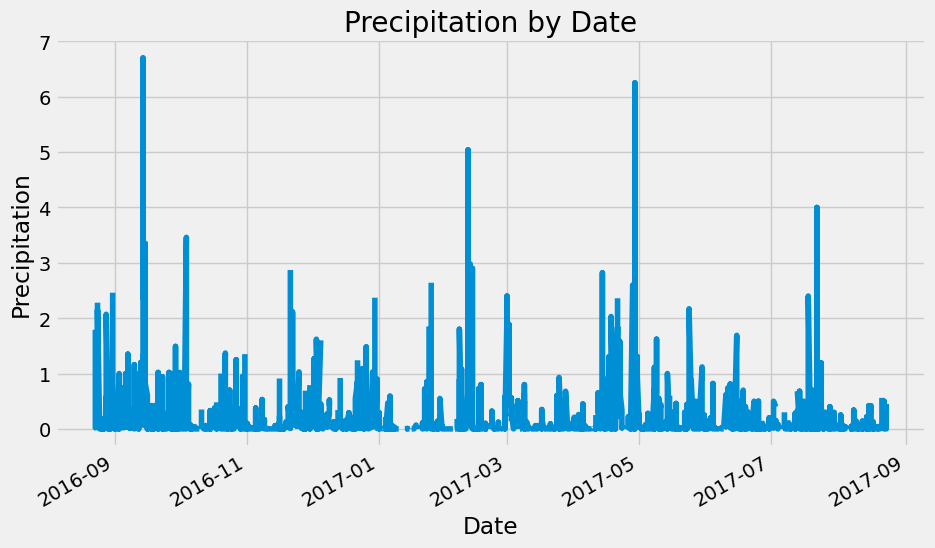

In [25]:
from datetime import datetime


# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
most_recent_date_as_string = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Convert the string date to a datetime object
most_recent_date = datetime.strptime(most_recent_date_as_string, '%Y-%m-%d')

# Calculate the date one year from the last date in data set
one_year_ago = (most_recent_date - pd.DateOffset(years=1)).date()

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago, Measurement.date <= most_recent_date_as_date) \
    .all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(last_year_precipitation, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
sorted_precipitation_df=precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
sorted_precipitation_df['Date'] = pd.to_datetime(sorted_precipitation_df['Date'])
sorted_precipitation_df.set_index('Date', inplace=True)

sorted_precipitation_df.plot(figsize=(10, 6), legend=False)
plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [26]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(func.distinct(Station.station))).scalar()
total_stations

9

In [29]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station_id) \
    .all()

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

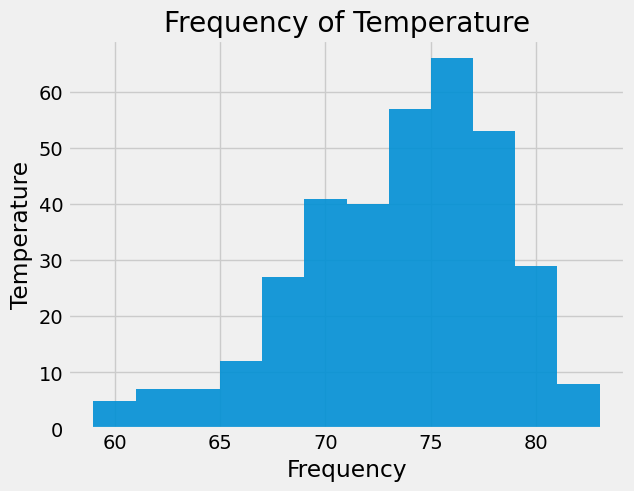

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_stats = session.query(Measurement.tobs, Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id) \
    .filter(Measurement.date >= one_year_ago, Measurement.date <= most_recent_date_as_date) \
    .all()
        
temperatures = [row[1] for row in station_stats]

plt.hist(temperatures, bins=12, alpha=0.9, label='Temperature')
plt.title('Frequency of Temperature')
plt.xlabel('Frequency')
plt.ylabel('Temperature')
plt.show()

# Close Session

In [34]:
# Close Session
session.close()